# Variance reduction

In [66]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Control variate

For $t>0$ and $x \in R$, we set $$f_t(x) = \frac{1}{1+t x^2}, \qquad g_t(x) = 1-t x^2.$$

In [8]:
def f(t,x):
  return 1/(1+t*x**2)

def g(t,x):
  return 1-t*x**2

For $X \sim \mathcal{N}(0,1)$, our aim is to estimate the value of $\mathcal{I}:=E[f_t(X)]$, using $Y=g_t(X)$ as a control variate. Note that $E[Y] = 1-t$.

With the notation of the lecture notes, complete the following code so that the function `MCandCV(t,X)` takes in input a number $t>0$ and an array $X$ which contains $n$ realisations of independent standard Gaussian variables, and returns the list $(\hat{\mathcal{I}}_n, \hat{\sigma}_n, \hat{\mathcal{I}}^\mathsf{CV}_n, \hat{\sigma}^\mathsf{CV}_n)$.

In [19]:
def MCandCV(t,X):
  n = len(X)
  fX = f(t,X)
  Y = g(t,X)

  mean_fX = np.mean(fX)
  mean_Y = np.mean(Y)

  var_fX = np.mean((fX-mean_fX)**2)
  var_Y = np.mean((Y-mean_Y)**2)
  cov_fX_Y = np.mean((fX-mean_fX)*(Y-mean_Y))

  beta = cov_fX_Y/var_Y

  estim_CV = np.mean(fX-beta*Y)+beta*(1-t)
  estim_var_CV = var_fX - cov_fX_Y**2/var_Y

  return [mean_fX,var_fX**.5,estim_CV,estim_var_CV**.5]

We use this function to plot the estimated values of $\mathcal{I}$ as a function of $t$ obtained with both the naive MC estimator and the CV estimator, together with respective $95\%$ confidence intervals.

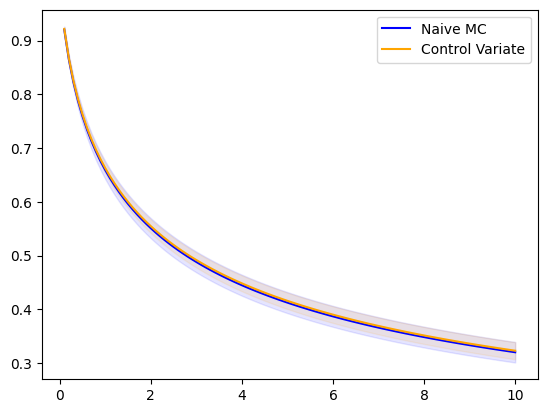

In [27]:
# Sample
nX = 1000
X = np.random.normal(0,1,nX)

# Values of t
nt = 100
t = np.linspace(.1,10,nt)

# Estimators and standard deviations
estim_MC = np.zeros(nt)
sigma_MC = np.zeros(nt)
estim_CV = np.zeros(nt)
sigma_CV = np.zeros(nt)

for i in range(nt):
  [estim_MC[i],sigma_MC[i],estim_CV[i],sigma_CV[i]] = MCandCV(t[i],X)

# Plot of estimators and 95% confidence intervals
plt.plot(t,estim_MC,label='Naive MC',color='blue')
plt.fill_between(t, estim_MC-1.96*sigma_MC/nX**.5, estim_MC+1.96*sigma_MC/nX**.5, color='blue', alpha=.1)

plt.plot(t,estim_CV,label='Control Variate',color='orange')
plt.fill_between(t, estim_CV-1.96*sigma_CV/nX**.5, estim_CV+1.96*sigma_CV/nX**.5, color='orange', alpha=.1)

plt.legend()
plt.show()

Using the quantities computed above, plot as a function of $t$ the ratio $\hat{\sigma}^\mathsf{CV}_n/\hat{\sigma}_n$, which quantifies the variance reduction due to the use of the control variate. What do you conclude?

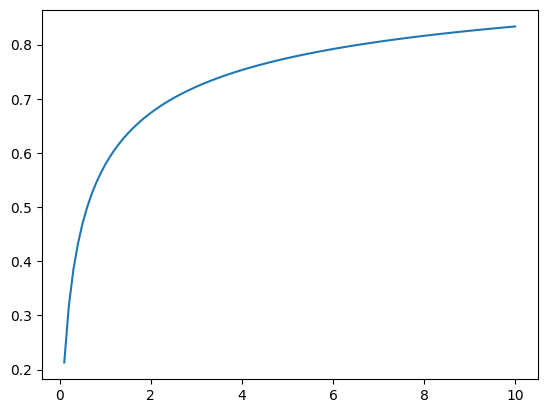

In [28]:
# Second plot
plt.plot(t, sigma_CV/sigma_MC)
plt.show()

## 2. Importance Sampling

For $p \in [0,1]$, we let $(X_n)_{n \geq 1}$ be a sequence of iid random variables such that $P(X_1=1)=p$, $P(X_1=-1)=1-p$. We next define $S_0 = 0$ and $S_{n+1} = S_n + X_{n+1}$, and for $N \geq 1$ we let $$T^\pm_N = \inf\{n \geq 1: S_n = \pm N\}.$$

We are interested in the evaluation of the probability of the event $\{T^+_N < T^-_N\}$, which is *small* when $p$ is close to $0$. In fact, it can be proved that we have
$$\mathcal{I} := P(T^+_N < T^-_N) = \begin{cases}
  1/2 & \text{if $p=1/2$;}\\
  \frac{1-\alpha^{-N}}{\alpha^N-\alpha^{-N}} & \text{otherwise;}
\end{cases} \qquad \alpha = \frac{1-p}{p}.$$
So when $p$ is small, this probability is equivalent to $p^N$.

We first fix values for $N$ and $p$.

In [82]:
p = .25 # Must be lower than .5
N = 5

proba_to_estim = (1-(1/p-1)**(-N))/((1/p-1)**N-(1/p-1)**(-N))

print("Probability to estimate:",proba_to_estim)

Probability to estimate: 0.004098360655737705


Our purpose is to fix $p$ small and to use importance sampling with random variables $(\tilde{X}_n)_{n \geq 1}$ which are such that $P(\tilde{X}_1=1)=q$, $P(\tilde{X}_1=-1)=1-q$. We denote by $\tilde{T}^\pm_N$ the associated hitting times of $\pm N$. We want to study variance reduction as a function of $q$.

Complete the following code so that the function `OneTraj(q)` returns a realisation of the pair $(\tilde{T}^+_N \wedge \tilde{T}^-_N, 1_{\tilde{T}^+_N < \tilde{T}^-_N})$.

In [83]:
def OneTraj(q):
  S = 0
  T = 0
  while (abs(S)<N):
    S = S + (2*np.random.binomial(1,q)-1)
    T = T+1
  return [T,S>0]

We now claim that for any $k \geq N$,
$$P(\tilde{T}^+_N \wedge \tilde{T}^-_N = k, \tilde{T}^+_N < \tilde{T}^-_N) = \left(\frac{q}{p}\right)^{(k+N)/2}\left(\frac{1-q}{1-p}\right)^{(k-N)/2}P(T^+_N \wedge T^-_N = k, T^+_N < T^-_N),$$
therefore the IS estimator of $\mathcal{I}$ writes
$$\hat{\mathcal{I}}^{\mathsf{IS},q}_n = \frac{1}{n}\sum_{i=1}^n w_q(\tilde{T}^{+,i}_N) 1_{\tilde{T}^{+,i}_N < \tilde{T}^{-,i}_N},$$
with
$$w_q(k) = \left(\frac{p}{q}\right)^{(k+N)/2}\left(\frac{1-p}{1-q}\right)^{(k-N)/2}.$$

Complete the following so that the function `IS(q,n)` returns an array of $n$ realisations $w_q(\tilde{T}^{+,i}_N) 1_{\tilde{T}^{+,i}_N < \tilde{T}^{-,i}_N}$.

In [84]:
def IS(q,n):
  vect_of_I = np.zeros(n)
  for i in range(n):
    [T,B] = OneTraj(q)
    if B:
      vect_of_I[i] = (p/q)**((T+N)/2)*((1-p)/(1-q))**((T-N)/2)
  return vect_of_I

To check that the IS estimator is unbiased, we plot its value as a function of $q$, together with the true value of $\mathcal{I}$.

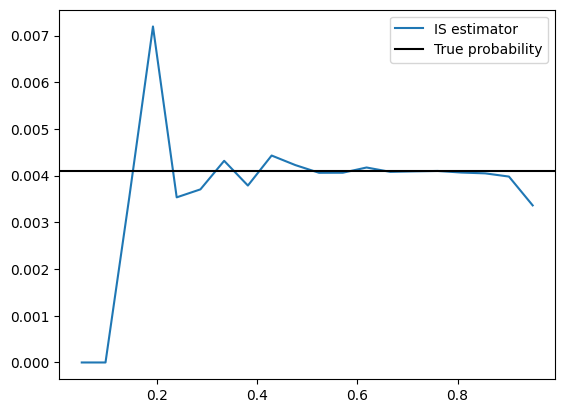

In [85]:
# Values of q
nq = 20
q = np.linspace(.05,.95,nq)

estim_IS = np.zeros(nq)

for i in range(nq):
  isq = IS(q[i],10000)
  estim_IS[i] = np.mean(isq)

plt.plot(q,estim_IS,label='IS estimator')
plt.axhline(y=proba_to_estim, color='black',label='True probability')
plt.legend()
plt.show()

Using a similar code, plot the empirical variance of $\hat{\mathcal{I}}^{\mathsf{IS},q}_n$ as a function of $q$. Which value of $q$ seems to be optimal?

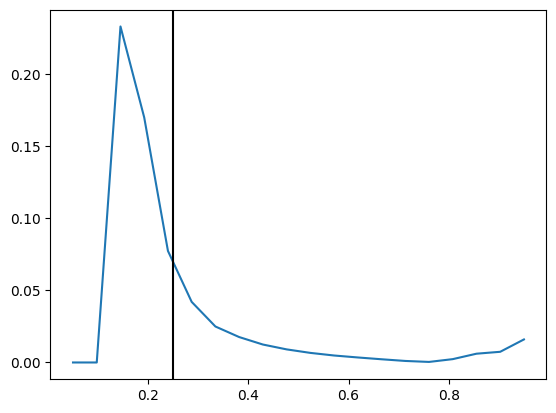

In [86]:
sigma_IS = np.zeros(nq)

for i in range(nq):
  isq = IS(q[i],10000)
  sigma_IS[i] = np.std(isq)

plt.plot(q,sigma_IS)
plt.axvline(x=p,color='black')
plt.show()

You may now try to play with the values of $p$ and $N$ to make the event $\{T^+_N < T^-_N\}$ even more unlikely, and see how IS performs.